In [15]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.applications import ResNet50
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.utils import class_weight
from tensorflow.keras.applications import VGG16  # adiciona isto ao topo do teu notebook



In [16]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print(e)


GPU memory growth enabled.


In [17]:
import os

# Caminho local para a pasta raiz do projeto
root_path = "./"  

# Listar diretórios no caminho raiz
print("📁 Diretórios no caminho raiz:")
print(os.listdir(root_path))

# Verificar conteúdo de um caminho específico
specific_path = os.path.join(root_path, "garbage-noaug-70-15-15")
if os.path.exists(specific_path):
    print(f"\n📁 Conteúdo de {specific_path}:")
    print(os.listdir(specific_path))
else:
    print(f"\n❌ Caminho {specific_path} não existe")

# Função para listar diretórios com profundidade
def list_dirs(path, indent=0):
    for item in os.listdir(path):
        full_path = os.path.join(path, item)
        if os.path.isdir(full_path):
            print(" " * indent + "📁 " + item)
            if indent < 4:
                list_dirs(full_path, indent + 2)
        else:
            print(" " * indent + "📄 " + item)

# Explorar estrutura de diretórios
print("\n📂 Estrutura de diretórios:")
list_dirs(root_path, 0)

📁 Diretórios no caminho raiz:
['.DS_Store', '.git', '.gitignore', 'garbage-dataset', 'garbage-noaug-70-15-15', 'models', 'model_checkpoint.h5', 'requirements.txt', 'SSC.ipynb', 'ssc.py', 'SSC_2_final_optimized.ipynb', 'SSC_3_modelo_LeakyReLU.ipynb', 'SSC_4.ipynb', 'SSC_Model_T_TransferLearning.ipynb', 'SSC_Model_T_TransferLearning_v2.ipynb', 'SSC_Model_T_TransferLearning_without_aug.ipynb']

📁 Conteúdo de ./garbage-noaug-70-15-15:
['.DS_Store', 'README.dataset.txt', 'README.roboflow.txt', 'test', 'train', 'valid']

📂 Estrutura de diretórios:
📄 .DS_Store
📁 .git
  📄 COMMIT_EDITMSG
  📄 config
  📄 description
  📄 FETCH_HEAD
  📄 HEAD
  📁 hooks
    📄 applypatch-msg.sample
    📄 commit-msg.sample
    📄 fsmonitor-watchman.sample
    📄 post-update.sample
    📄 pre-applypatch.sample
    📄 pre-commit.sample
    📄 pre-merge-commit.sample
    📄 pre-push.sample
    📄 pre-rebase.sample
    📄 pre-receive.sample
    📄 prepare-commit-msg.sample
    📄 push-to-checkout.sample
    📄 sendemail-validate.samp

In [18]:
# Improved Metal GPU detection for Apple Silicon
try:
    # First try looking for GPU devices (newer TF versions label Metal as GPU)
    gpus = tf.config.list_physical_devices('GPU')
    if len(gpus) > 0:
        print(f"Found {len(gpus)} GPU device(s)")
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU acceleration enabled (Metal)")
    # If no GPU found, try looking specifically for MPS devices
    elif hasattr(tf.config, 'list_physical_devices') and len(tf.config.list_physical_devices('MPS')) > 0:
        mps_devices = tf.config.list_physical_devices('MPS')
        tf.config.experimental.set_visible_devices(mps_devices[0], 'MPS')
        print("MPS (Metal) device enabled")
    else:
        print("No GPU or MPS device found, using CPU")
        
    # Verify what device is being used
    print("\nDevice being used:", tf.config.get_visible_devices())
    
    # Test with a simple operation to confirm GPU usage
    with tf.device('/GPU:0'):
        a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
        b = tf.constant([[5.0, 6.0], [7.0, 8.0]])
        c = tf.matmul(a, b)
        print("Matrix multiplication result:", c)
        print("GPU test successful!")
except Exception as e:
    print(f"Error setting up GPU: {e}")
    print("Falling back to CPU")

Found 1 GPU device(s)
GPU acceleration enabled (Metal)

Device being used: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Matrix multiplication result: tf.Tensor(
[[19. 22.]
 [43. 50.]], shape=(2, 2), dtype=float32)
GPU test successful!


In [19]:
# Enable mixed precision (faster on GPU)
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')  # Use FP16 instead of FP32

In [20]:
train_dir = specific_path + "/train"
validation_dir = specific_path + "/valid"
test_dir = specific_path + "/test"

IMG_SIZE = 128
BATCH_SIZE = 32

# 1. Carregar dataset com augmentation
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

# Extrair rótulos dos batches do dataset
train_labels = np.concatenate([y.numpy() for x, y in train_dataset], axis=0)

# Calcular os pesos das classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))

val_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

# Aumentar o dataset de treinamento com técnicas de data augmentation (das classes minoritárias)
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_saturation(image, 0.8, 1.2)
    image = tf.image.random_hue(image, 0.05)
    return image, label

# Definir classes minoritárias
minority_classes = [0, 1, 5, 6, 9]  # battery, biological, metal, paper, trash

def augment_conditionally(image, label):
    return tf.cond(
        tf.reduce_any([tf.equal(label, tf.constant(c)) for c in minority_classes]),
        lambda: augment_image(image, label),
        lambda: (image, label)
    )

train_dataset_aug = train_dataset.map(augment_conditionally, num_parallel_calls=tf.data.AUTOTUNE)


Found 13833 files belonging to 10 classes.


2025-06-05 19:13:04.916604: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Found 2965 files belonging to 10 classes.
Found 2964 files belonging to 10 classes.


In [21]:
# DataAugmentation
# data_augmentation = keras.Sequential(
# [
# layers.RandomFlip("horizontal"),
# layers.RandomRotation(0.1),
# layers.RandomZoom(0.2),
# ]
# )

In [22]:
class_names = train_dataset.class_names

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# 2. Feature Extraction – VGG16 congelada
base_model = VGG16(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # congelado inicialmente

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [23]:
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Aplicar data augmentation
#x = data_augmentation(inputs)
# Normalização
x = layers.Rescaling(1./255)(inputs)

# Extrator de features (ResNet50 congelada)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)

# Camadas densas otimizadas
x = layers.Dropout(0.3)(x)

x = layers.Dense(512)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.4)(x)

x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.4)(x)

# Saída
outputs = layers.Dense(len(class_names), activation='softmax')(x)

# Modelo final
model = keras.Model(inputs, outputs)

# Compilação
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Resumo
model.summary()

# EarlyStopping mais agressivo
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,114,314 (57.66 MB)

 Trainable params: 398,090 (1.52 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

In [24]:
# 4. Treino com feature extraction
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[early_stopping]
)

# 5. Fine-tuning – descongela últimas camadas
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Novo EarlyStopping para fine-tuning
early_stopping_ft = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Opcional: ajuste dinâmico da LR
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)

# Treino com fine-tuning
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[early_stopping_ft, reduce_lr],
    class_weight=class_weights
)



model.save_weights('models/vgg16_finetuned.weights.h5')
# Salvar o modelo completo
model.save('models/vgg16_finetuned_model.h5')
print("Modelo salvo como 'vgg16_finetuned_model.h5' e pesos como 'vgg16_finetuned_weights.h5'.")  

Epoch 1/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 32s 52ms/step - accuracy: 0.3292 - loss: 2.0560 - val_accuracy: 0.7116 - val_loss: 0.9173
Epoch 2/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.5786 - loss: 1.2519 - val_accuracy: 0.7589 - val_loss: 0.7587
Epoch 3/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.6380 - loss: 1.0864 - val_accuracy: 0.7804 - val_loss: 0.6918
Epoch 4/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.6702 - loss: 0.9855 - val_accuracy: 0.7970 - val_loss: 0.6417
Epoch 5/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.6830 - loss: 0.9420 - val_accuracy: 0.8020 - val_loss: 0.6150
Epoch 6/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.6940 - loss: 0.9028 - val_accuracy: 0.8118 - val_loss: 0.5923
Epoch 7/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.7088 - loss: 0.8516 - val_accuracy: 0.8148 - val_loss: 0.5811
Epoch 8/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.7254 - loss: 0.8203 - 

2025-06-05 19:20:13.882001: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k2=4,k4=1,k5=3,k6=3,k7=2} for conv %cudnn-conv-bw-input.12 = (f16[32,8,8,512]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,8,8,512]{3,2,1,0} %bitcast.18345, f16[512,3,3,512]{3,2,1,0} %bitcast.17677), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardInput", metadata={op_type="Conv2DBackpropInput" op_name="gradient_tape/functional_1_1/vgg16_1/block5_conv3_1/convolution/Conv2DBackpropInput" source_file="/home/diogo/venvs/tf-env/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-05 19:20:13.920562: I external/local_xla/xla/service/gpu/autotun

432/433 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8062 - loss: 0.6512

2025-06-05 19:22:02.702113: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k2=4,k4=1,k5=3,k6=3,k7=2} for conv %cudnn-conv-bw-input.12 = (f16[9,8,8,512]{3,2,1,0}, u8[0]{0}) custom-call(f16[9,8,8,512]{3,2,1,0} %bitcast.18370, f16[512,3,3,512]{3,2,1,0} %bitcast.17714), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardInput", metadata={op_type="Conv2DBackpropInput" op_name="gradient_tape/functional_1_1/vgg16_1/block5_conv3_1/convolution/Conv2DBackpropInput" source_file="/home/diogo/venvs/tf-env/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-05 19:22:02.705339: I external/local_xla/xla/service/gpu/autotunin

433/433 ━━━━━━━━━━━━━━━━━━━━ 139s 131ms/step - accuracy: 0.8063 - loss: 0.6509 - val_accuracy: 0.8759 - val_loss: 0.3685 - learning_rate: 1.0000e-05
Epoch 2/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 36s 82ms/step - accuracy: 0.8665 - loss: 0.4499 - val_accuracy: 0.8951 - val_loss: 0.3259 - learning_rate: 1.0000e-05
Epoch 3/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 36s 82ms/step - accuracy: 0.8920 - loss: 0.3457 - val_accuracy: 0.8897 - val_loss: 0.3295 - learning_rate: 1.0000e-05
Epoch 4/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 36s 82ms/step - accuracy: 0.9110 - loss: 0.2895 - val_accuracy: 0.9052 - val_loss: 0.2821 - learning_rate: 1.0000e-05
Epoch 5/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 36s 82ms/step - accuracy: 0.9252 - loss: 0.2526 - val_accuracy: 0.9130 - val_loss: 0.2627 - learning_rate: 1.0000e-05
Epoch 6/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 36s 82ms/step - accuracy: 0.9382 - loss: 0.2051 - val_accuracy: 0.9126 - val_loss: 0.2582 - learning_rate: 1.0000e-05
Epoch 7/30
433/433 ━━━━━━━━━━━━━━━━━━━━ 36s 82ms/step - accur

Modelo salvo como 'resnet50_finetuned_model.h5' e pesos como 'resnet50_finetuned_weights.h5'.


93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.9316 - loss: 0.2072
Test accuracy: 0.9325236082077026
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 984ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━

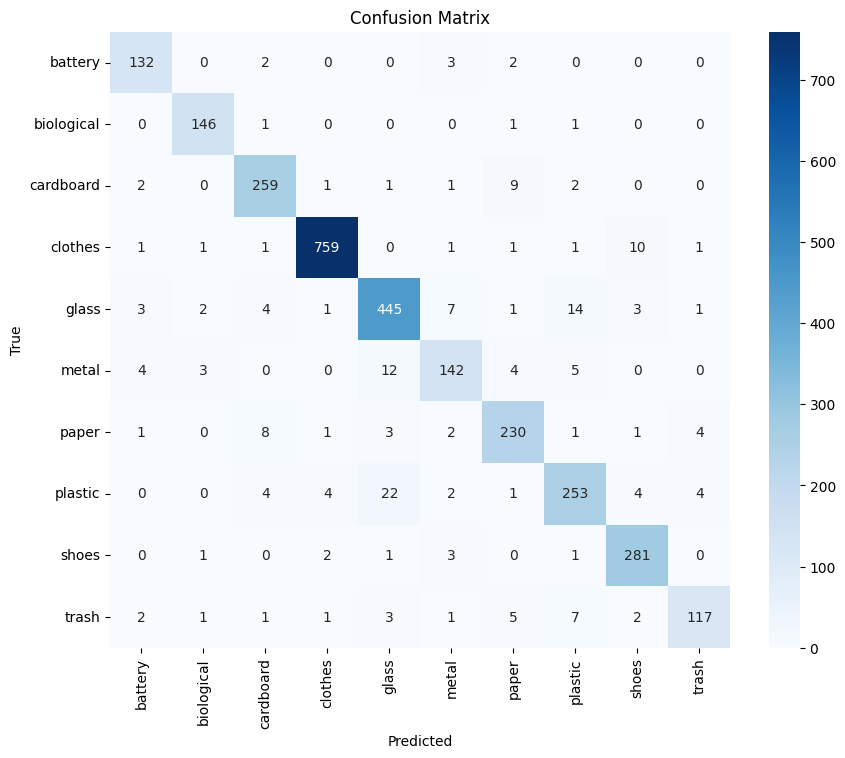

In [25]:
# 7. Avaliação
test_loss, test_acc = model.evaluate(test_dataset)
print("Test accuracy:", test_acc)

# 8. Previsões para métricas
y_pred = []
y_true = []

for images, labels in test_dataset:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

# 9. Relatório e Confusion Matrix
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

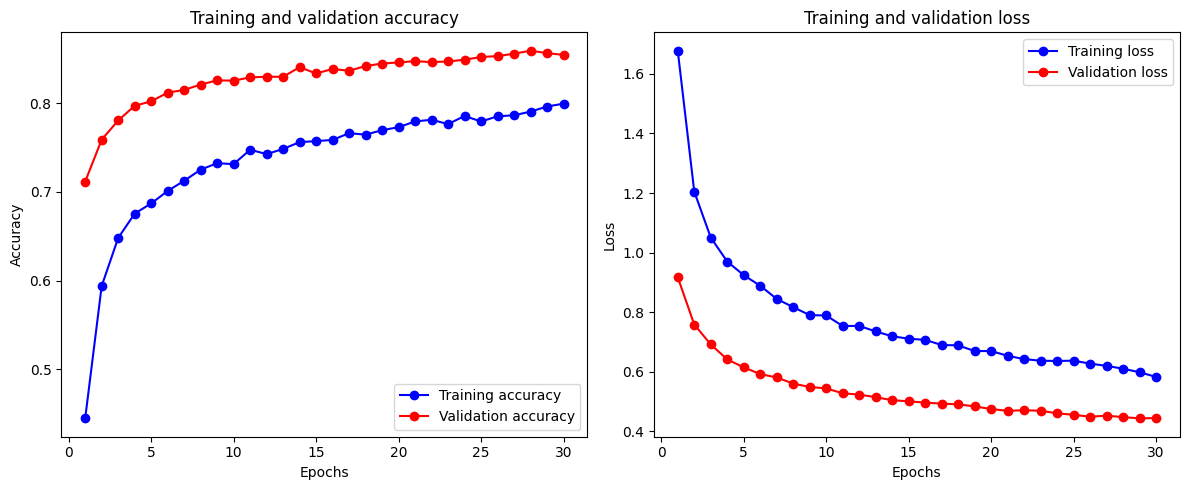

In [26]:
# Corrected plotting code for newer TensorFlow versions
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9307 - loss: 0.2128
Test accuracy: 0.9325
Test loss: 0.2146
Classes: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


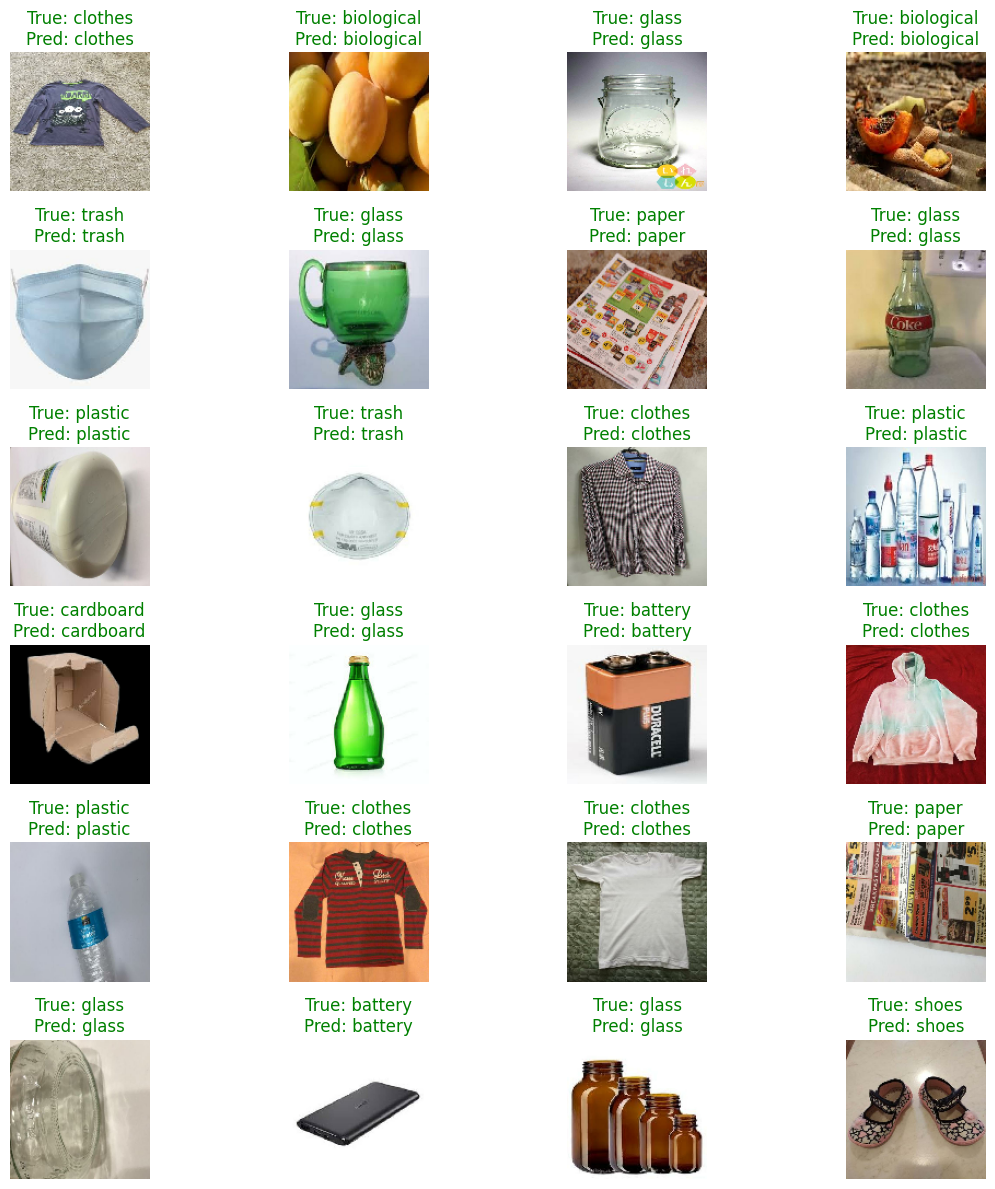

In [27]:
# Evaluate on test dataset
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Visualize some predictions
import numpy as np

# Use the already defined class_names variable
print("Classes:", class_names)

# Function to show predictions for a batch of images
plt.figure(figsize=(12, 12))
for images, labels in test_dataset.take(1):
    predictions = model.predict(images)
    pred_classes = np.argmax(predictions, axis=1)
    
    for i in range(24):
        plt.subplot(6, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        correct = labels[i] == pred_classes[i]
        color = "green" if correct else "red"
        
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[pred_classes[i]]}", 
                 color=color)
        plt.axis("off")
plt.tight_layout()
plt.show()